In [1]:
import pathlib
import numpy as np
import more_itertools as mit
import re

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

from tqdm.notebook import trange, tqdm

from six.moves import cPickle

import os

from scipy import signal as spsig
from scipy.signal import argrelextrema
from scipy.signal import argrelmin

#### Utility Functions

In [2]:
# def glob_files(path, pattern=r'**/*.dat'):
#     yield from (file for file in data_dir.glob('**/*.dat'))
#     
# 
# def _extract_digit(pattern, text):
#     """ helper for extract_bw_and_sf """
#     try:
#         match = int(re.search(pattern, text)[1])
#     except:
#         print('ERROR! unable to extract bw or sf')
#         return 
#     else:
#         return match 
    
#     
# def extract_bw_and_sf(filename, BW_val):
#     """ extracts params from input filename """
#     #_bw_pattern, _sf_pattern, _l_pattern = r'BW(\d)', r'SF(\d{1,})', r'L(\d{1,})'
#     _bw_pattern, _sf_pattern, _l_pattern = r'BW(\d)', r'SF(\d{1,})', r'Att(\d{1,})'
#     bw_match = _extract_digit(_bw_pattern, filename)
#     
#     if bw_match is not None:
#         bw_match = BW_val[bw_match - 1]
#     
#     sf_match = _extract_digit(_sf_pattern, filename)
#     
#     l_match = _extract_digit(_l_pattern, filename)
#     
#     return bw_match, sf_match, l_match

# def check_and_load_file(filepath):
#     filepath = pathlib.Path(filepath)
#     
#     if not isinstance(filepath, pathlib.Path) or not filepath.exists():
#         print(f'ERROR! unable to find input file at:\n{filepath}')
#         return
#         
#     return filepath


# def _average_packet_length():
#     sampPerSym = np.round(((2**SF)/BW)*Fs)
#     pcktLen = 30.25*sampPerSym
#     return pcktLen



### get encoding parameters
# 
# def get_and_set_encoding_params(filepath):
#     BW_val = np.array([1, 2, 0, 0, 0, 0, 7, 8, 9])
#     BW_val2 = np.array([0,10.4e3, 15.6e3, 0, 0, 0, 0, 125e3, 250e3, 500e3])
#     BW, SF, Att= extract_bw_and_sf(filepath.name, BW_val) 
#     
#     Fs = int(1e6)
# 
#     sampPerSym = np.round(((2**SF)/BW_val2[BW])*Fs)
#     pcktLen = 30.25*sampPerSym
# 
#     print(f'BW: {BW} | SF: {SF} | Fs: {Fs} | Samples Per Symbol: {sampPerSym} | Packet Length: {pcktLen}')
#     return BW, SF, sampPerSym, Att


# ## load data
# def load_data(filepath):
#     try:
#         signal = np.fromfile(filepath, dtype=np.complex64)
#     except Exception as exc:
#         print(f'unable to load file:\n{exc}')
#         return 
#     else:
#         #print(f'loaded signal with {signal.size} samples')
#         return signal

    
## normalize signal
def normalize_signal(signal, th=0.001):
    real_s = np.abs(np.real(signal)) 
    
    norm_s = np.array([
        np.ceil(val) if val >= th else 0
        for val in real_s
    ])
    return real_s, norm_s


### locate zero indices
def _locate_zero_indices(norm_signal):
    indices = np.where(norm_signal == 0.0)[0]
    
    return indices

### find consecutive groups 
def _find_consecutive_groups(zero_indexes):
    groups = [
        list(j) for j in 
        mit.consecutive_groups(sorted(list(set(zero_indexes))))
    ]
    
    lengths = np.array(
        [len(item) for item in groups]
    )
    
    #print(f'found {len(groups)} groups')
    return groups, lengths

### locate endpoints
def _locate_endpoints(groups, threshold=15_000):
    all_endpoints = [
        endpoints for group in groups
            if len(group) > threshold
        for endpoints in (group[0], group[-1])
    ]
    
    endpoint_pairs = [
        (start, stop) 
        for start, stop in zip(all_endpoints[1::2], all_endpoints[2::2])
    ]
    
    #print(f'Extracted {len(endpoint_pairs)} packets from signal')
    return endpoint_pairs

## extract endpoints
def plot_groups(indexes, lengths, filename):
    fig, axs = plt.subplots(2)
    fig.suptitle(f'{filename}')
    axs[0].plot(indexes)
    axs[1].plot(lengths)
    
    #plt.savefig(f'plots/{filename}.png')
    return fig

def extract_endpoints(normalized_signal, filename, threshold=15_000):
    zero_indexes = _locate_zero_indices(normalized_signal)
    consec_groups, groups_lengths = _find_consecutive_groups(zero_indexes)

    # validation plot 
    plot_groups(zero_indexes, groups_lengths, filename)
    
    endpoint_pairs = _locate_endpoints(consec_groups, threshold)
    return endpoint_pairs

def extract_indices(signal, scale_factor=101, window_length=17_500):
    real_s, down_s = preprocess(signal, scale_factor, window_length)
    
    packet_len = _average_packet_length()
    minima = find_minima(down_s, window=packet_len//scale_factor)
    
    _plot_comparison(real_s, down_s, minima)
    return minima 


def extract_endpoints_od(signal, scale_factor=101, window_length=17_500):
    minima = extract_indices(signal, scale_factor, window_length)
    
    endpoints = _generate_endpoints(minima, scale_factor, sampPerSym)
    return endpoints


def find_minima(signal, window=8_000):
    minima = spsig.argrelmin(signal, order=int(window))[0]
    
    return minima


def _generate_minima_plot(minima, size):
    minima_plot = np.zeros(size)
    
    for val in minima:
        minima_plot[val] = 1 
        
    return minima_plot


def _moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


def _plot_comparison(real, down, minima):
    fig, axs = plt.subplots(3)
    fig.set_figwidth(10), fig.set_figheight(12)
    axs[0].plot(real[100_000:])
    axs[1].plot(down[1000:])
    axs[2].plot(_generate_minima_plot(minima, down.size)[1000:])




def preprocess(signal, scale_factor, window_length=17_500):
    real_s = np.abs(np.real(signal))
    
    down_s = _moving_average(
        spsig.decimate(real_s, scale_factor, ftype='iir'), 
        n=window_length // scale_factor
    )
    print(f'decimated by a factor of {scale_factor} | size: {down_s.size}')
    
    return real_s, down_s
    


## packet slicing
def _slice_and_pad(signal, endpoints, length):
    start, stop = endpoints
    sliced = signal[start:stop] 
    
    if len(sliced) < length:
        sliced = np.concatenate((
            sliced, np.zeros(length - len(sliced))
        ))
        
    return sliced


def slice_all_packets(signal, endpoints):
    max_length = max(stop - start for start, stop in endpoints)
    print(f'got max packet length: {max_length}')
    
    packets = np.vstack(
        tuple(
            _slice_and_pad(signal, pair, max_length)
            for pair in endpoints
        )
    )
    
    #print(f'Extracted {len(packets)} packets from signal')
    return packets


def _generate_endpoints(minima, scale, sampPerSym):
    packet_length = 30.25*sampPerSym
    return [
        (int(val*scale), int(val*scale+packet_length))
        for val in minima
    ]

def reshape_symbol_sets(d, num_samples):
    num_symbols, sym_len  = d.shape
    
    if sym_len < num_samples:
        R = int(np.ceil(num_samples/sym_len))
        N = int(np.floor(num_symbols/R))
    else:
        return d
        
    
    final_data = np.empty((N, num_samples), dtype='complex')
    
    for idx, r in enumerate(range(R, N, R)):
        # r is the row selectors for the start of each set to be reshaped
        last_r = last_r if r != R else 0
        
        data = d[last_r:r, :]
        d1d = np.reshape(data, data.size)
        final_data[idx, :] = d1d

        last_r = r
        
    return final_data





# -------------------------------- packet adjusting --------------------------------

def check_and_adjust(endpoints, packets, look_ahead=100, threshold=0.8, plots=False):
    if packets.shape[0] != len(endpoints):
        print('ERROR: length of endpoints and packets do not match')
    
    new_endpoints  = []
    
    for idx in range(len(endpoints)):
        adjusted_endpoints = _slice_and_process(endpoints, packets, idx, look_ahead, threshold, plots)
        new_endpoints.append(adjusted_endpoints)
        
    return new_endpoints
        

def _slice_and_process(endpoints, packets, index, look_ahead, threshold, plots):
    threshold = 0.75*threshold if index == 0 else threshold
    print(f' processing packet {index} '.center(75, '='))
    tar_endpoints = endpoints[index]
    tar_packet = np.abs(np.real(packets[index, :]))
        
    adjustment = _strip_packets(tar_packet, look_ahead, threshold, plots)
    final_start, final_stop = _adjust_endpoints(tar_endpoints, adjustment)
    print(f'set final endpoints: {final_start} : {final_stop}')
    
    return final_start, final_stop
    
    
def _strip_packets(packet, look_ahead, threshold, plots):
#     packet_mean = packet.mean()
    packet_mean = _biased_packet_mean(packet, bias=0.7)
    threshold *= packet_mean 
    start, stop = 0, 0+look_ahead
    print(f'packet mean: {packet_mean:0.5f}')
    adjustment = 0
    
    while stop < packet.size:
        diff = abs(packet[start:stop].mean() - packet_mean)

        if diff > threshold:
#             print(f'[{start}:{stop}] diff: {diff:0.5f}, suspect padding slice')
            start, stop = stop, stop + look_ahead

        else:
            adjustment = start            
            print(f'got final adjustments {adjustment}')
            break
            
    return adjustment
    

def _biased_packet_mean(packet, bias=0.7):
    packet = np.real(np.abs(packet))
    packet_max = packet.max()
    
    biased_packet = packet[np.where(packet > bias * packet_max)]
    
    print(f'got biased packet [{biased_packet.size} / {packet.size}] [{biased_packet.mean():0.5f} / {packet.mean():0.5f}]')
    return biased_packet.mean()

    
def _adjust_endpoints(original, adjustment):
    orig_start, orig_stop = original
    
    return orig_start + adjustment, orig_stop + adjustment




def _plot_old_packet(index, ax=None):
    if ax is None:
        plt.plot(packets[index,:])
    else:
        ax.plot(packets[index,:])
    
def _plot_new_packet(index, ax=None):
    if ax is None:
        plt.plot(new_packets[index,:])
    else:
        ax.plot(new_packets[index,:])
    
def compare_packets(index):
    fig, axs = plt.subplots(2)
    fig.set_figwidth(10), fig.set_figheight(8)
    _plot_old_packet(index, axs[0])
    _plot_new_packet(index, axs[1])
    


#### Define Data Directory

In [3]:
data_dir = pathlib.Path('data/LoRa_Recording_Outdoor')
all_data_files = list(glob_files(data_dir))

print("# of files: " + str(len(all_data_files)))

# of files: 20


In [4]:
all_data_files

[PosixPath('data/LoRa_Recording_Outdoor/lora_BW9_SF8_915MHz_1Msps_L42.dat'),
 PosixPath('data/LoRa_Recording_Outdoor/lora_BW8_SF12_915MHz_1Msps_Att80_v0.dat'),
 PosixPath('data/LoRa_Recording_Outdoor/lora_BW2_SF12_915MHz_1Msps_Att80_v0.dat'),
 PosixPath('data/LoRa_Recording_Outdoor/lora_BW8_SF11_915_25MHz_1Msps_L37.dat'),
 PosixPath('data/LoRa_Recording_Outdoor/lora_BW8_SF10_915MHz_1Msps_Att80_v0.dat'),
 PosixPath('data/LoRa_Recording_Outdoor/lora_BW9_SF12_915MHz_1Msps_Att80_v0.dat'),
 PosixPath('data/LoRa_Recording_Outdoor/lora_BW2_SF10_915MHz_1Msps_Att80_v0.dat'),
 PosixPath('data/LoRa_Recording_Outdoor/lora_BW9_SF10_915MHz_1Msps_L1.dat'),
 PosixPath('data/LoRa_Recording_Outdoor/lora_BW1_SF12_915MHz_1Msps_Att70_v3.dat'),
 PosixPath('data/LoRa_Recording_Outdoor/lora_BW7_SF11_915MHz_1Msps_Att80_v0.dat'),
 PosixPath('data/LoRa_Recording_Outdoor/lora_BW1_SF11_915MHz_1Msps_Att80_v0.dat'),
 PosixPath('data/LoRa_Recording_Outdoor/lora_BW1_SF10_915MHz_1Msps_Att80_v0.dat'),
 PosixPath('data/L

### Function to extract packets, symbols, & save data

In [5]:
def extract_packets(filepath, norm_thresh=0.001, packet_thresh=15_000):
    filepath = check_and_load_file(filepath)    
    #print(f'norm threshold: {norm_thresh}')
    
    get_and_set_encoding_params(filepath) 
    signal = load_data(filepath)
    
    #N = 3_000_000 
    N = len(signal)
    
    real_s, norm_s = normalize_signal(signal[0:N], norm_thresh)
    #print("Normalization Complete")
  
    endpoint_pairs = extract_endpoints(norm_s, filepath.name, packet_thresh)
    print("Endpoint Pairs Extracted. Total: " + str(np.shape(endpoint_pairs)))
    
    x = np.shape(np.asarray(endpoint_pairs))
    if x[0] != 0:
        all_packets = slice_all_packets(signal[0:N], endpoint_pairs)
        print("Total Packets: " + str(np.shape(all_packets)))
    
        return all_packets
    else: 
        return [0]

def extract_symbols(packets, numPackets, sampPerSym):
    
    if sampPerSym < np.asarray(packets).shape[1]:
        # Get Params
        numSymbols = 8

        #print("Total Packet:" + str(numPackets))
        #print("Symbols to Extract: " + str(numSymbols))

        
        symbols = np.empty([numPackets*numSymbols,sampPerSym], dtype='complex')
        N = symbols.shape[0]
        k,l = 0, 0

        for i in range(numPackets):
            for j in range(numSymbols):
                symbols[l,:] = packets[i,k:k+sampPerSym]
                k = k + sampPerSym
                l = l+1
            k = 0

        print("# of symbols extract: " + str(symbols.shape[0]))
        return symbols
    else:
        return [0]

def save_data(symbols, dir_, filename):
    if str(os.path.exists(dir_+filename)) == 'True':

        with open(dir_+filename, mode='rb') as file:        
            d = cPickle.load(file)  
            
        d = np.concatenate([np.asarray(d), np.asarray(symbols)])
        
        print('Appending to file...')
        print('Total Symbols:' + str(d.shape))
        cPickle.dump(d, open(dir_+filename,'wb'))
        
    else:
        cPickle.dump(symbols, open(dir_+filename,'wb'))
    print("Saved data to:" + str(filename))

In [6]:
file = all_data_files[-2]
print(file.name)
BW, SF, sampPerSym, L = get_and_set_encoding_params(file)
BW, SF, sampPerSym = int(BW), int(SF), int(sampPerSym)
print(BW, SF, L)
pcktLen = int(30.25*sampPerSym)
print(f'packet length: {pcktLen}')

lora_BW1_SF11_915MHz_1Msps_Att70_v3.dat
BW: 1 | SF: 11 | Fs: 1000000 | Samples Per Symbol: 196923.0 | Packet Length: 5956920.75
1 11 70
packet length: 5956920


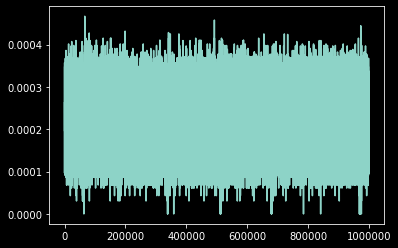

In [7]:
signal = load_data(file)
plt.plot(np.real(np.abs((signal[1_000_000:2_000_000]))))

#done: 4, 5,1,2

# hack it out 

In [8]:
padding_length = 17_000

print(f'''
stats
           BW: {BW}          SF: {SF}  
          min: {np.real(signal).min():0.5f}  max: {np.real(signal).max():0.5f}
         mean: {np.real(signal).mean():0.5f}  std: {np.real(signal).std():0.5f}
         
    samples per symbol:  {sampPerSym}
         packet length:  {pcktLen}
        padding length:  {padding_length}
          total length:  {signal.size}
''')

real_s = np.real(np.abs(signal))


stats
           BW: 1          SF: 11  
          min: -0.00046  max: 0.00052
         mean: -0.00000  std: 0.00016
         
    samples per symbol:  196923
         packet length:  5956920
        padding length:  17000
          total length:  105457352



## functions 

In [9]:
def _plot_slidemean_data(data, mindex, plot):
    if not plot:
        return 
    
    if mindex+padding_length > data.size:
        print(f'too close to edge of slice, shifting and retrying..')
        return
        
    tar = np.zeros(data.size)
    tar[mindex] = 1.1*data.max()
    tar[mindex+padding_length] = 1.1*data.max()

    fig, axs = plt.subplots(2)
    axs[0].plot(data[mindex:mindex+padding_length])
    axs[1].plot(data)
    axs[1].plot(tar)



def find_all_mindices(signal, overlap=0.5):
    real_s = np.real(np.abs(signal))
    
    all_indexes = []
    base = 0
    
    while True:
        if base % 50 == 0:
            print(f'iter {base}')
        
        try:
            index = _scan_chunk(signal, real_s, base, overlap, plot=False)
        except StopIteration:
            break
        else:
            all_indexes.append(index)
            base += 1
            
    cleaned_indexes = _clean_all_indexes(all_indexes)
    print(f'found [{len(all_indexes)} // {len(cleaned_indexes)}] packets')
    return cleaned_indexes
        
     
    
def _scan_chunk(signal, real_s, base, overlap, plot=False):
    start, stop = int((base+0.25)*pcktLen), int((base+1.5)*pcktLen)
    
    if stop > real_s.size:
        print(f'reached end of signal')
        raise StopIteration
    
    mindex = _slide_and_mean(real_s[start:stop], overlap, plot=False)
    absindex = start + mindex
#     print(f'absolute mindex: {absindex}')
    
    _plot_fft_packet(signal, absindex, plot)
    return absindex


    
def _slide_and_mean(data, overlap=0.5, plot=False):
    step = int(overlap * padding_length)
    indices = list(range(step, data.size, step))
    
    argmin = np.argmin([
        data[idx:idx+padding_length].mean()
        for idx in indices
    ])
    min_index = indices[argmin]

#     print(f'argmin: {argmin} // min index: {min_index}')
    _plot_slidemean_data(data, min_index, plot)
    
    return min_index
    
    
    
def _plot_fft_packet(signal, absindex, plot):
    if not plot:
        return 
    
    packet = signal[absindex: int(absindex + pcktLen + padding_length)]
        
    fig, axs = plt.subplots(2)
    axs[0].plot(packet)
    axs[1].plot(np.fft.fftshift(np.abs(np.fft.fft(packet))))

 
    
def _clean_all_indexes(indexes):
    diffy = np.diff(np.array(indexes))
    to_drop = list(np.where(diffy < 0)[0] + 1)
    print(f'len of drop: {len(to_drop)}')
    
    return [idx for i,idx in enumerate(indexes) if i not in to_drop]


def _generate_endpoint_pairs_from_indices(indices):
    return [
        (idx, idx+pcktLen)
        for idx in indices
    ]

## slide and mean

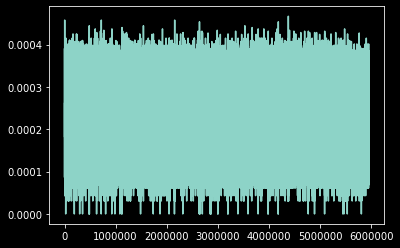

In [10]:
data = real_s[int(0.25*pcktLen):int(1.25*pcktLen)]
plt.plot(data)

In [11]:
all_indices = find_all_mindices(signal, overlap=0.7)
endpoints = _generate_endpoint_pairs_from_indices(all_indices)

iter 0
reached end of signal
len of drop: 0
found [17 // 17] packets


In [12]:
packets = slice_all_packets(signal, endpoints)

got max packet length: 5956920


In [14]:
# adjust packets 
new_endpoints = check_and_adjust(
    endpoints[:], packets[:], 
    look_ahead=100, threshold=0.8,
)

new_packets = slice_all_packets(signal, new_endpoints)

=========================== processing packet 0 ===========================
got biased packet [107113 / 5956920] [0.00031 / 0.00014]
packet mean: 0.00031
got final adjustments 0
set final endpoints: 4333330 : 10290250
=========================== processing packet 1 ===========================
got biased packet [20071 / 5956920] [0.00034 / 0.00014]
packet mean: 0.00034
got final adjustments 4100
set final endpoints: 10306250 : 16263170
=========================== processing packet 2 ===========================
got biased packet [3297 / 5956920] [0.00037 / 0.00014]
packet mean: 0.00037
got final adjustments 0
set final endpoints: 16259070 : 22215990
=========================== processing packet 3 ===========================
got biased packet [82703 / 5956920] [0.00031 / 0.00014]
packet mean: 0.00031
got final adjustments 0
set final endpoints: 22215990 : 28172910
=========================== processing packet 4 ===========================
got biased packet [3844 / 5956920] [0.00037 / 0.00

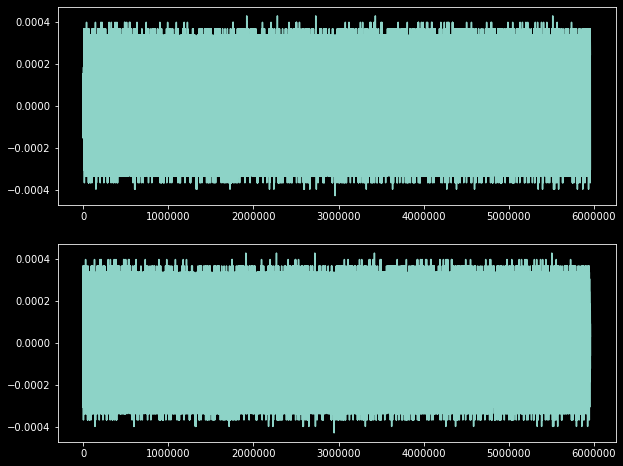

In [17]:
compare_packets(7)